In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle
from google.colab import drive
drive.mount('/content/drive')
import os
import time

%matplotlib inline

debugging_mode = 0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext autoreload
#using autoreload 1 to reload all modules imported by %aimport everytime before executing the python code typed .
%autoreload 1

%aimport lane

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from google.colab.patches import cv2_imshow

vidloc = r"/content/drive/My Drive/test images/project_video.mp4"
w_path = r"/content/drive/My Drive/yolov3.weights"
c_path = r"/content/drive/My Drive/yolov3.cfg"

labels = open(r"/content/drive/My Drive/coco.names").read().strip().split("\n")

net = cv2.dnn.readNetFromDarknet(c_path, w_path)
names = net.getLayerNames()
layers_names = [names[i[0]-1] for i in net.getUnconnectedOutLayers()]

cap = cv2.VideoCapture(vidloc)
W = int(cap.get(3))
H = int(cap.get(4))
fps=int(cap.get(5))
count=0
fcount=0
out_stream=[]
while cap.isOpened():
    ret, frame = cap.read()
   
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    final = lane.vid_pipeline(frame)
    # final=frame
    count=count+1
    fcount=fcount+1
    time1=time.time()
    if(count==1):
      blob = cv2.dnn.blobFromImage(final, 1/255.0, (416,416), crop=False, swapRB = False)
      net.setInput(blob)
      layers_output = net.forward(layers_names)
      # print("image into network time is",time.time()-time1)
      boxes=[]
      confidences=[]
      classIDs=[]

      # time1=time.time()
      for output in layers_output:
        for detection in output:
          scores=detection[5:]
          classID = np.argmax(scores)
          confidence = scores[classID]

          if(confidence>0.85):
            box=detection [:4] * np.array([W, H, W, H])
            bx, by, bw, bh = box.astype("int")
            Px= int(bx-(bw/2))
            Py= int(by-(bh/2))
            boxes.append([Px,Py,int(bw),int(bh)])
            confidences.append(float(confidence))
            classIDs.append(classID)

    idxs= cv2.dnn.NMSBoxes(boxes,confidences,0.8,0.8)
    # print("extracting data time is ",time.time()-time1)
    # print(idxs)

    # time1=time.time()
    if(len(idxs)>0):
        for i in idxs.flatten():
          (x,y) = [boxes[i][0], boxes[i][1]]
          (w,h) = [boxes[i][2],boxes[i][3]]

          cv2.rectangle(final,(x,y),(x+w,y+h),(200,100,0),2)
          cv2.putText(final,"{} : {}%".format(labels[classIDs[i]],int(confidences[i]*100)),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(200,100,0),2)
    # print("Printing data time is ")
    
    # count=count+1
    if(count==10):
      count=0
    final =cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
    out_stream.append(final)
    # cv2_imshow(final)
    print("frame {} is done".format(fcount),time.time()-time1)

    
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter('video_c.avi', fourcc, 25, (W,H))

for j in range(len(out_stream)-1):
  img = out_stream[j]
  video.write(img)
  
cv2.destroyAllWindows()
video.release()





In [ ]:
from google.colab.patches import cv2_imshow

vidloc = r"/content/drive/My Drive/test images/challenge_video.avi"

cap = cv2.VideoCapture(vidloc)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps=int(cap.get(5))
print(fps)
count=0
out_stream=[]
while cap.isOpened():
    ret, frame = cap.read()
   
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    final = lane.vid_pipeline(frame)
    count=count+1
    print("frame",count)
    out_stream.append(final)
    
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter('video_c.avi', fourcc, 25, (frame_width,frame_height))

for j in range(len(out_stream)-1):
  img = out_stream[j]
  video.write(img)
  
cv2.destroyAllWindows()
video.release()

Text(0.5, 1.0, 'Gradient')

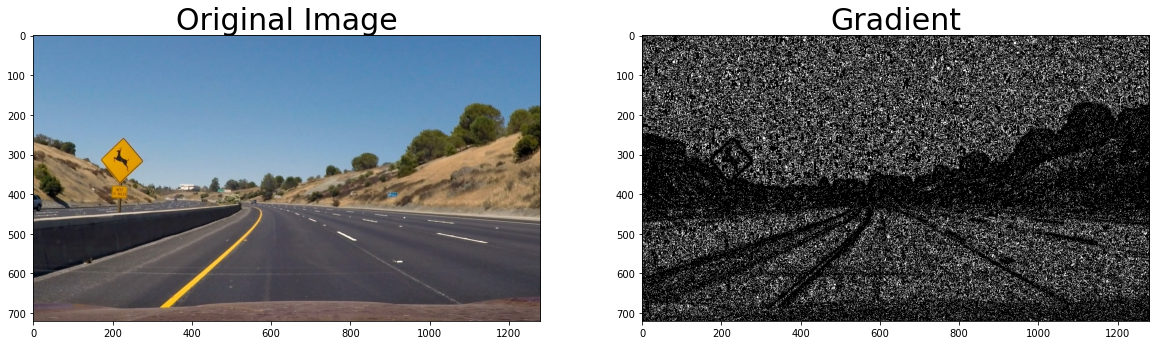

In [ ]:
from google.colab.patches import cv2_imshow
loc = r"/content/drive/My Drive/test images/test2.jpg"
# vidloc = r"/content/drive/My Drive/test images/challenge_video.avi"
# img=cv2.imread(loc)
img = cv2.imread(loc)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
dst = lane.abs_sobel_thresh(gray, thresh=(np.pi/10, np.pi/2))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap="gray")
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Gradient', fontsize=30)

Text(0.5, 1.0, 'Masked')

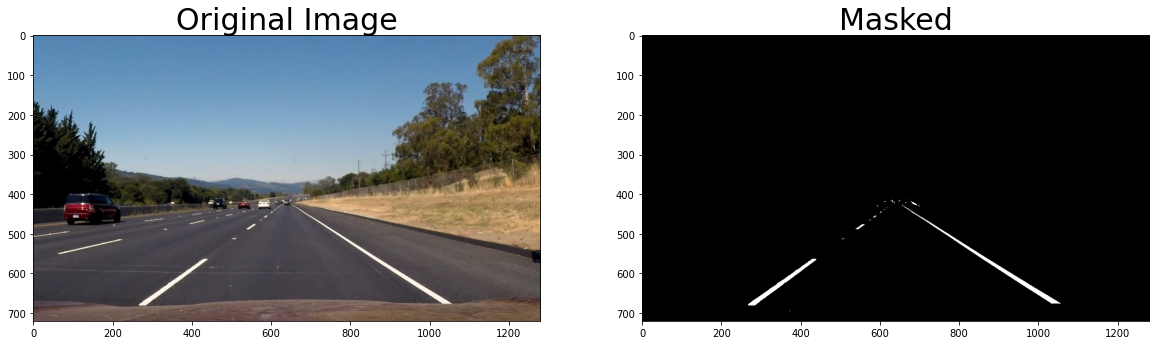

In [ ]:
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = lane.combine_thresh(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap="gray")
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Masked', fontsize=30)

Text(0.5, 1.0, 'Warp')

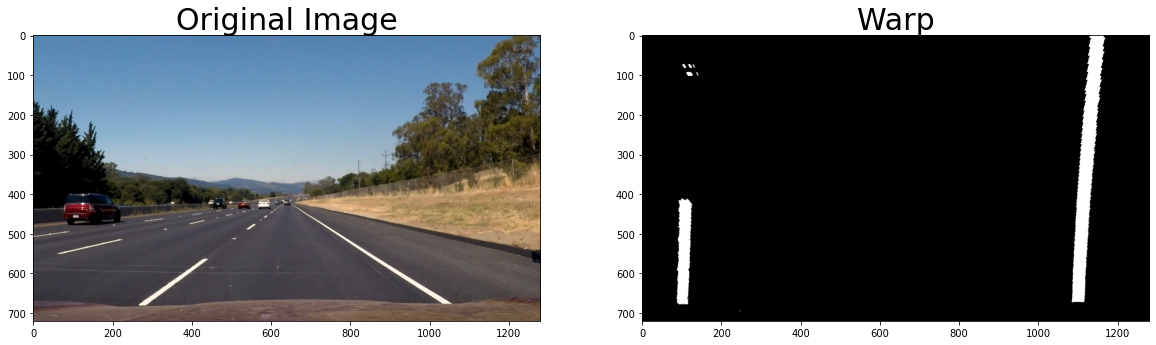

In [ ]:
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = lane.combine_thresh(img)
dst = lane.perspective_warp(dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap="gray")
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Warp', fontsize=30)

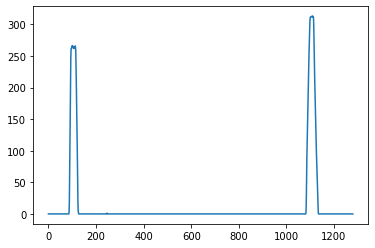

In [ ]:
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = lane.combine_thresh(img)
dst = lane.perspective_warp(dst)
                            
histo = lane.get_hist(dst)
x_hist = np.array(range(0, 1280))
plt.plot(x_hist, histo)

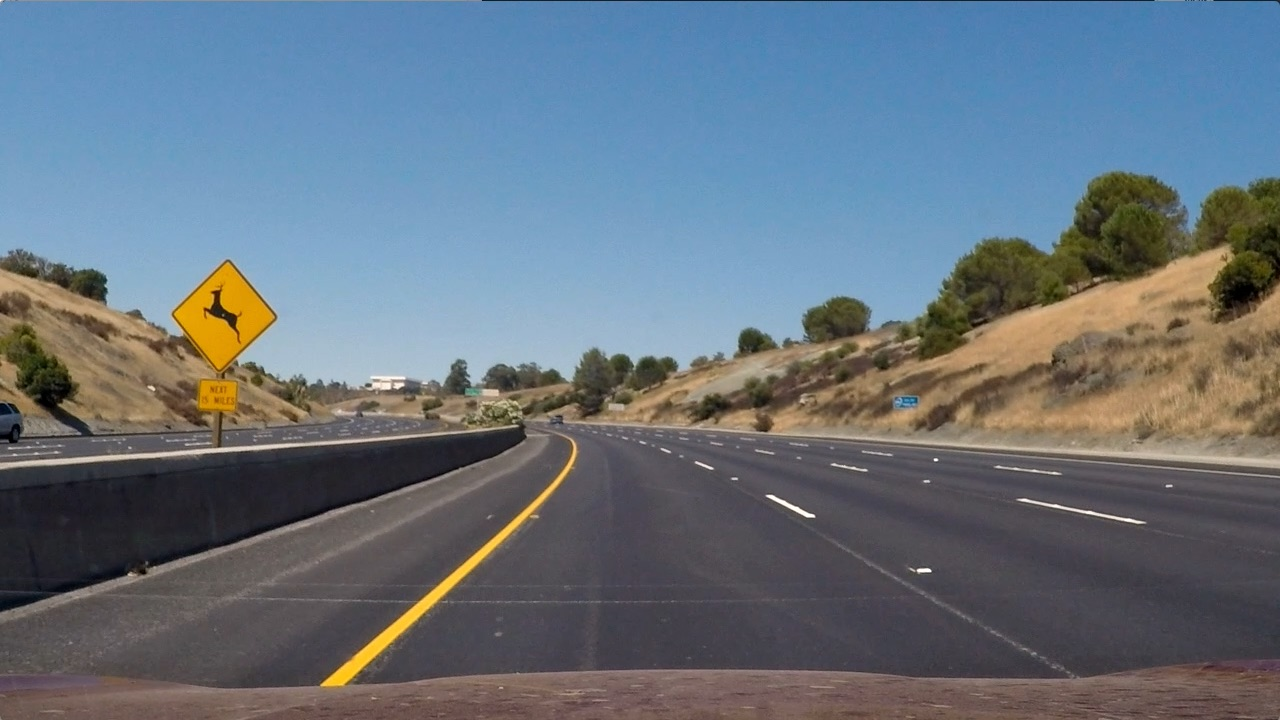

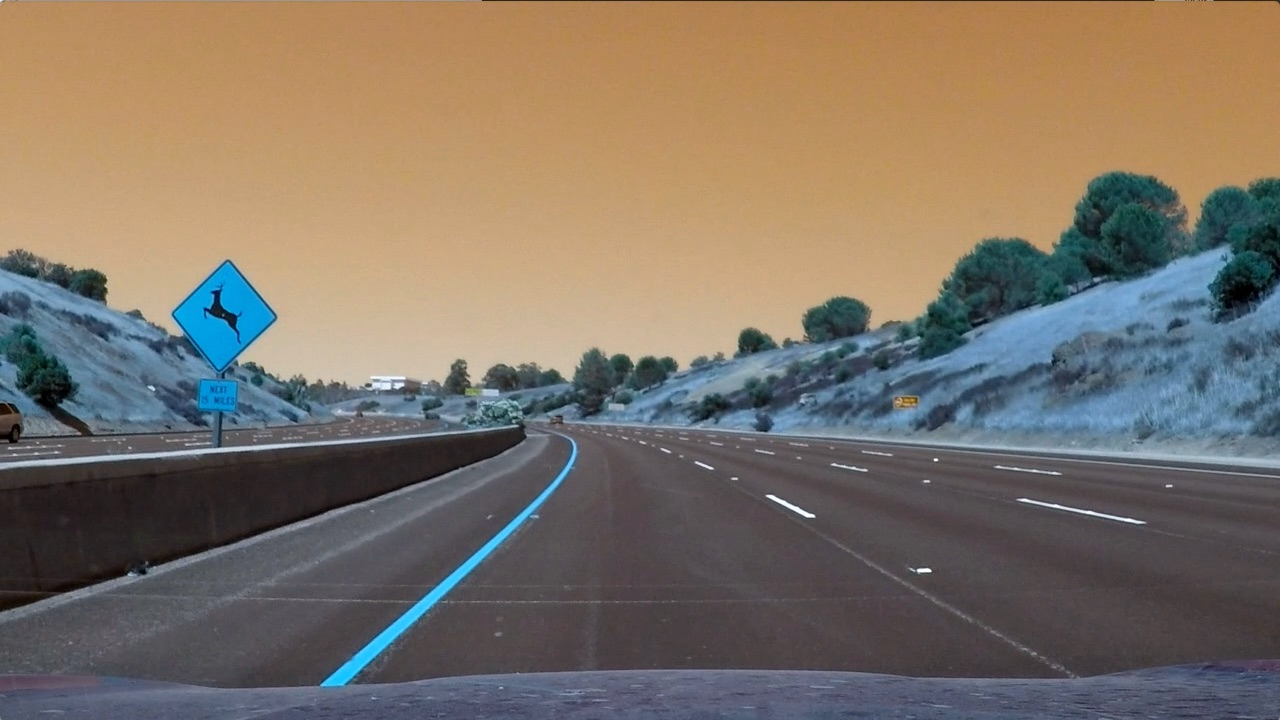

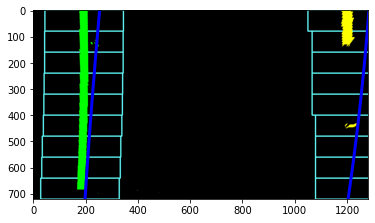

In [ ]:
from google.colab.patches import cv2_imshow
loc = r"/content/drive/My Drive/test images/test2.jpg"
img = cv2.imread(loc)
cv2_imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = lane.combine_thresh(img)
dst = lane.perspective_warp(dst)
out_img, curves, lanes, ploty = lane.sliding_window(dst)
plt.imshow(dst)
plt.plot(curves[0], ploty, color='blue', linewidth=3)
plt.plot(curves[1], ploty, color='blue', linewidth=3)

curverad= lane.get_curve(img, curves[0],curves[1])

img_ = lane.draw_lanes(img, curves[0], curves[1])
plt.imshow(out_img, cmap='hsv')